In [1]:
!pwd


/home/animeshs/notebooks


In [2]:
import numpy as np
def parseMGF(mgfData):
    data = mgfData.read_text().split('\n')
    _comments = '#;!/'
    reading_spectrum = False
    params = {}
    masses = []
    intensities = []
    charges = []
    out = {}
    cnt = 0
    pep_mass = 0
    pep_intensity = 0
    out = {}
    for line in data:
        if not reading_spectrum:
            if line.strip() == 'BEGIN IONS': reading_spectrum = True
        else:
            if not line.strip() or any(line.startswith(c) for c in _comments): pass
            elif line.strip() == 'END IONS':
                reading_spectrum = False
                title = params['title'].split()[0]
                if 'pepmass' in params:
                    try:
                        pl = params['pepmass'].split()
                        if len(pl) > 1:
                            pep_mass = float(pl[0])
                            pep_intensity = float(pl[1])
                        elif len(pl) == 1: pep_mass = float(pl[0])
                    except ValueError: print("Error in parsing pepmass value")
                out[cnt] = {'pep_mass': pep_mass,'pep_intensity': pep_intensity,'rtinseconds': params['rtinseconds'],'title': params['title'],'charge': params['charge'],'mz_array': np.array(masses),'intensity_array': np.array(intensities)}
                cnt += 1
            else:
                l = line.split('=', 1)
                if len(l) > 1: params[l[0].lower()] = l[1].strip()
                elif len(l) == 1:  # looks like a peak list ;)
                    l = line.split()
                    if len(l) >= 2000:
                        try:
                            masses.append(float(l[0]))
                            intensities.append(float(l[1]))
                        except ValueError:
                            print("Error in parsing line "+line)
    return out

In [3]:
import pathlib
#file = pathlib.Path.cwd().parent.rglob('*.MGF')
file = pathlib.Path.home()/'mgf' / '190128_robin_WT_5.raw.centroid.MGF'
#file = pathlib.Path.home()/'mgf' / '190128_robin_ 6' / '190128_robin_WT_5.mgf'
print(file.exists())#read_text().split(' '))
out=parseMGF(file)

True


In [4]:
X=[(out[k]['pep_mass']-1.00727647)*int(out[k]['charge'].split('+')[0]) for k, _ in out.items()]
X_mz1=np.array(X).reshape(-1, 1)
print(X_mz1.shape)

(57969, 1)


In [5]:
X=[(out[k]['pep_intensity']) for k, _ in out.items()]
X_int=np.array(X).reshape(-1, 1)
print(X_int.shape)

(57969, 1)


In [6]:
X=[np.float(out[k]['rtinseconds']) for k, _ in out.items()]
X_rt=np.array(X).reshape(-1, 1)
print(X_rt.shape)

(57969, 1)


In [7]:
k=0
print(out[k],X_int[k],X_mz1[k],X_rt[k])

{'pep_mass': 388.894256591797, 'rtinseconds': '0.66099936', 'mz_array': array([], dtype=float64), 'intensity_array': array([], dtype=float64), 'title': '2\t11\tSCANS=FTMS + c NSI d Full ms2 388.8943@hcd29.00 [54.0000-810.0000]', 'charge': '2+', 'pep_intensity': 216.3578859} [216.3578859] [775.77396024] [0.66099936]


In [8]:
import matplotlib.pyplot as plt
#plt.hist(X_rt)
#plt.hist(np.log2(X_mz1))
#plt.scatter(X_mz1, int(X_rt))
print(X_mz1, X_rt)

[[ 775.77396024]
 [ 871.74673856]
 [ 774.67178739]
 ...
 [1196.88901151]
 [1301.6269743 ]
 [2288.28108807]] [[6.60999360e-01]
 [3.83577924e+00]
 [5.14044030e+00]
 ...
 [1.07996430e+04]
 [1.07997720e+04]
 [1.07999028e+04]]


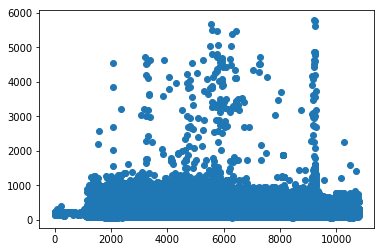

In [12]:
import matplotlib.pyplot as plt
#plt.hist(X_rt)
#plt.hist(np.log2(X_mz1))
#plt.scatter(X_rt,X_mz1,X_int)
plt.scatter(X_rt,X_int)

/home/animeshs/.local/lib/python3.5/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


[-16.94128     -2.2898886    2.249615   ...   0.88102627   2.249615
  -2.2898886 ] [[-80.       -80.       -80.       ... -20.349545 -18.931133 -21.612713]
 [-80.       -80.       -80.       ... -12.727091 -13.151951 -16.21872 ]
 [-80.       -80.       -80.       ... -18.368595 -20.529575 -12.801571]
 ...
 [-80.       -80.       -80.       ... -71.05459  -72.94654  -69.85945 ]
 [-80.       -80.       -80.       ... -71.15897  -70.52577  -70.17508 ]
 [-80.       -80.       -80.       ... -70.46967  -71.69782  -70.10464 ]]


(array([ 12., 573., 196.,  66.,  28.,  56.,  49.,  22.,  16.,   6.]),
 array([-61.2039  , -53.97716 , -46.75042 , -39.52368 , -32.296944,
        -25.070206, -17.843466, -10.616727,  -3.389988,   3.836751,
         11.06349 ], dtype=float32),
 <a list of 10 Patch objects>)

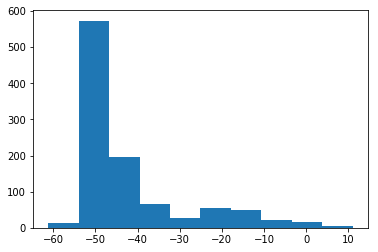

In [18]:
import librosa
from scipy.fftpack import fft
n_fft = 1024
hop_length = 256
n_mels = 40
f_min = 20
f_max = 8000
fmin = 20
fmax = 8000
n_fft = 1024
sample_rate = 16000
sample_rate = 16000
clip, sample_rate = librosa.load('HareKrishna.mp3', sr=None)
clip = clip[:132300] # first three seconds of file
n_fft = 1024  # frame length 
start = 45000 # start at a part of the sound thats not silence
x = clip[start:start+n_fft]
X = fft(x, n_fft)
X_magnitude, X_phase = librosa.magphase(X)
X_magnitude_db = librosa.amplitude_to_db(X_magnitude)
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, sr=sample_rate, power=1.0, fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

([array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([39.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([39.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([40.,  0.,  0., 

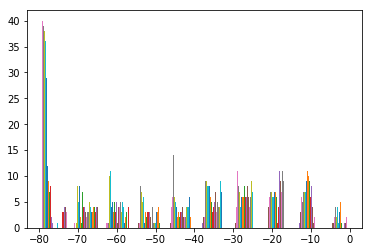

In [21]:
#print(X_magnitude_db,mel_spec_db)
plt.hist(X_magnitude_db)

In [31]:
#from  rulsif import RULSIF
#from cycler import cycler
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import backend

2.0.0-alpha0


In [32]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend
model = Sequential()
model.add(GaussianNoise(STD_DEV, input_shape=(MAX_WORDS, vectors.dim)))
model.add(Bidirectional(LSTM(HIDDEN_UNITS, activation='tanh'), merge_mode='concat'))
model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(num_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=LEARNING_RATE),metrics=['categorical_accuracy'])

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [24]:
base_model=keras.applications.xception.Xception(include_top=True, 
                                                weights='imagenet', 
                                                input_tensor=None, 
                                                input_shape=None, 
                                                pooling=None, 
                                                classes=1000)
x=base_model.output
#x=GlobalAveragePooling4D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(2,activation='softmax')(x)

NameError: name 'keras' is not defined

In [ ]:
model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
for layer in model.layers[:20]:    layer.trainable=False
for layer in model.layers[20:]:    layer.trainable=True

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('./subCellular',
                                                  target_size=(299,299),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical', 
                                                  shuffle=True)
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,epochs=2)

In [ ]:
model.save('modelMGF.h5')    
!bzip2 'modelMGF.h5'

In [ ]:
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 16} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [ ]:
import pandas as pd
# import formatter as fm
df = pd.read_csv('Groups.txt',sep='\t')
df.head()

In [ ]:
#check also https://github.com/kusterlab/prosit/blob/master/prosit/prediction.py

In [ ]:
!mkdir  ~/.kaggle
!cp $PWD/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -lthr ~/.kaggle/

In [ ]:
#!$HOME/.local/bin/kaggle datasets download -d piotrgrabo/breastcancerproteomes --force
!$HOME/.local/bin/kaggle competitions download -c human-protein-atlas-image-classification

In [ ]:
!find $HOME -iname train

In [ ]:
!pip install -U -q PyDrive --user
!pip install -U -q google.colab --user

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

In [ ]:
!ls -ltrh

In [ ]:
outvec=[1 if 'positive' in i.parts[-2] else 0 for i in trainlist]
outvec

In [ ]:
outvecclip=outvec[0:99]

In [ ]:
(outvecclip)

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(MGF, binary_labels, test_size = .2)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=71, shuffle=True, random_state=42)
batches = [train for test, train  in kf.split(X_train, y_train)]
batches[0].shape

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
test_batches = [t_batch for _, t_batch  in kf.split(X_test, y_test)]
np.histogram(test_batches[9])

In [ ]:
X_train.shape,X_test.shape

In [ ]:
predictions = [result for p in pred for result in p ]
predictions

In [ ]:
from  sklearn.metrics import accuracy_score,log_loss #ytrue ypred
log_loss(y_test, [[p[0],1-p[0]] for p in predictions])

In [ ]:
np.round([p[0] for p in predictions])

In [ ]:
# Compute confusion matrix
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in predictions]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()

<a href="https://colab.research.google.com/github/animesh/notebooks/blob/master/tfMGF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
*peptide spectra predictor*
- [Novo](https://github.com/nh2tran/DeepNovo)
- [Post](https://github.com/semiller10/postnovo)